# KITTI Dataset Exploration

In [23]:
!pip install moviepy
!pip install numpy
!pip install pykitti
!pip install opencv-python

In [24]:
## prerequisites

#!pip3 install pykitti
#!pip3 install moviepy

# download the synced and rectified dataset. do not need the unsynced dataset
#wget http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip

#wget http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_tracklets.zip


In [25]:
# unzip files
#import zipfile
#targetdir = "KITTI_data"
#with zipfile.ZipFile("/home/ubuntu/2011_09_26_drive_0001_sync.zip","r") as zip_ref:
#    zip_ref.extractall(targetdir)
#    print("done")

In [26]:
#with zipfile.ZipFile("/home/ubuntu/2011_09_26_calib.zip","r") as zip_ref:
#    zip_ref.extractall(targetdir)
#    print("done")

In [27]:
#with zipfile.ZipFile("/home/ubuntu/2011_09_26_drive_0001_tracklets.zip","r") as zip_ref:
#    zip_ref.extractall(targetdir)
#    print("done")

In [28]:
import numpy as np
import pykitti
import matplotlib.pyplot as plt

# Change this to the directory where you store KITTI data
basedir = "/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset"

def load_dataset(date, drive, calibrated=False, frame_range=None):
    """
    Loads the dataset with `date` and `drive`.
    
    Parameters
    ----------
    date        : Dataset creation date.
    drive       : Dataset drive.
    calibrated  : Flag indicating if we need to parse calibration data. Defaults to `False`.
    frame_range : Range of frames. Defaults to `None`.

    Returns
    -------
    Loaded dataset of type `raw`.
    """
    dataset = pykitti.raw(basedir, date, drive)

    # Load the data
    if calibrated:
        dataset._load_calib()  # Calibration data are accessible as named tuples

    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frames))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

    return dataset

In [29]:
from source import parseTrackletXML as xmlParser

def load_tracklets_for_frames(n_frames, xml_path):
    """
    Loads dataset labels also referred to as tracklets, saving them individually for each frame.

    Parameters
    ----------
    n_frames    : Number of frames in the dataset.
    xml_path    : Path to the tracklets XML.

    Returns
    -------
    Tuple of dictionaries with integer keys corresponding to absolute frame numbers and arrays as values. First array
    contains coordinates of bounding box vertices for each object in the frame, and the second array contains objects
    types as strings.
    """
    #print(xml_path)
    tracklets = xmlParser.parseXML(xml_path)

    frame_tracklets = {}
    frame_tracklets_types = {}
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []

    # loop over tracklets
    for i, tracklet in enumerate(tracklets):
        # this part is inspired by kitti object development kit matlab code: computeBox3D
        h, w, l = tracklet.size
        # in velodyne coordinates around zero point and without orientation yet
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        
        print(tracklets)
        # loop over all data in tracklet
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
            # determine if object is in the image; otherwise continue
            if truncation not in (xmlParser.TRUNC_IN_IMAGE, xmlParser.TRUNC_TRUNCATED):
                continue
            # re-create 3D bounding box in velodyne coordinate system
            yaw = rotation[2]  # other rotations are supposedly 0
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber] + [
                tracklet.objectType]

    return (frame_tracklets, frame_tracklets_types)

Load the dataset downloaded from [KITTI website](http://www.cvlibs.net/datasets/kitti/raw_data.php). 

[2011_09_26_drive_0001 (0.4 GB)](http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip)

* **Length**: 114 frames (00:11 minutes)
* **Image resolution**: `1392 x 512` pixels
* **Labels**: 12 Cars, 0 Vans, 0 Trucks, 0 Pedestrians, 0 Sitters, 2 Cyclists, 1 Trams, 0 Misc

In [30]:
basedir = "/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset"
date = '2011_09_26'
drive = '0048'
dataset = pykitti.raw(basedir, date, drive)

print(dataset._load_calib)

<bound method raw._load_calib of <pykitti.raw.raw object at 0x127703518>>


In [31]:
date = '2011_09_26'
drive = '0048'
dataset = load_dataset(date, drive,calibrated=True)


directory = "/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset"
tracklet_rects, tracklet_types = load_tracklets_for_frames(len(list(dataset.velo)), '{}/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(directory,date, date, drive))


Drive: 2011_09_26_drive_0048_sync

Frame range: None

IMU-to-Velodyne transformation:
[[ 1.      0.0008 -0.002  -0.8087]
 [-0.0008  0.9999 -0.0148  0.3196]
 [ 0.002   0.0148  0.9999 -0.7997]
 [ 0.      0.      0.      1.    ]]

Gray stereo pair baseline [m]: 0.537150600501

RGB stereo pair baseline [m]: 0.532725440079
Parsing tracklet file /Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset/2011_09_26/2011_09_26_drive_0048_sync/tracklet_labels.xml
File contains 8 tracklets
Loaded 8 tracklets.
[<source.parseTrackletXML.Tracklet object at 0x1033a3470>, <source.parseTrackletXML.Tracklet object at 0x1033a3400>, <source.parseTrackletXML.Tracklet object at 0x1033a33c8>, <source.parseTrackletXML.Tracklet object at 0x1033a3358>, <source.parseTrackletXML.Tracklet object at 0x1033a34a8>, <source.parseTrackletXML.Tracklet object at 0x1033a34e0>, <source.parseTrackletXML.Tracklet object at 0x1033a3518>, <source.parseTrackletXML.Tracklet object at 0x1033a3550>]
[<

In [32]:
print(dataset.calib.T_cam3_imu)
print(dataset.calib.T_cam3_velo)

[[ 0.001  -1.      0.0043 -0.7846]
 [ 0.0084 -0.0043 -1.      0.7195]
 [ 1.      0.001   0.0084 -1.0891]
 [ 0.      0.      0.      1.    ]]
[[ 0.0002 -0.9999 -0.0106 -0.4734]
 [ 0.0104  0.0106 -0.9999 -0.0751]
 [ 0.9999  0.0001  0.0105 -0.2721]
 [ 0.      0.      0.      1.    ]]


In [33]:
from source import dataset_utility as du

In [34]:
import numpy as np
def parse_string_variable(str):
    var_name = str.split(':')[0]
    after_colon_index = len(var_name) + 1
    value = str[after_colon_index:]
    return (var_name, value)

def read_lines_to_dict(raw_text):
    var_list = []
    for i, line in enumerate(raw_text):
        var_list.append(line.replace('\n', ''))
    for i, line in enumerate(raw_text):
        var_list[i] = parse_string_variable(line)
    return dict(var_list)

def read_files_by_lines(filename):
    assert type(filename) is str
    with open(filename, 'r') as cam_to_cam:
#         data = cam_to_cam.read().replace('\n', 'r')
        data = cam_to_cam.readlines()
    return read_lines_to_dict(data)

def replace_var_from_dict_with_shape(var_dict, key, shape):
    return np.array(var_dict[key]).reshape(shape)


# TODO: 
# 1 if calibration completely found?
# 2 if rectification available
# 3 Deal with delta_f delta_t

def loadCalibrationCamToCam(filename, verbose=False):
    assert type(filename) is str
    cam_dict = read_files_by_lines(filename)

    for key, value in cam_dict.items():
        if key == 'calib_time':
            cam_dict[key] = value
        else:
            array = []
            for i, string in enumerate(value.split(' ')[1:]):
                array.append(float(string))
            cam_dict[key] = array

    for i in range(0, 4):
        S_rect_0i = 'S_rect_0' + str(i)
        R_rect_0i = 'R_rect_0' + str(i)
        P_rect_0i = 'P_rect_0' + str(i)
        S_0i = 'S_0' + str(i)
        K_0i = 'K_0' + str(i)
        D_0i = 'D_0' + str(i)
        R_0i = 'R_0' + str(i)
        T_0i = 'T_0' + str(i)

        cam_dict[S_rect_0i] = replace_var_from_dict_with_shape(cam_dict, S_rect_0i, (1, 2))
        cam_dict[R_rect_0i] = replace_var_from_dict_with_shape(cam_dict, R_rect_0i, (3, 3))
        cam_dict[P_rect_0i] = replace_var_from_dict_with_shape(cam_dict, P_rect_0i, (3, 4))
        cam_dict[S_0i] = replace_var_from_dict_with_shape(cam_dict, S_0i, (1, 2))
        cam_dict[K_0i] = replace_var_from_dict_with_shape(cam_dict, K_0i, (3, 3))
        cam_dict[D_0i] = replace_var_from_dict_with_shape(cam_dict, D_0i, (1, 5))
        cam_dict[R_0i] = replace_var_from_dict_with_shape(cam_dict, R_0i, (3, 3))
        cam_dict[T_0i] = replace_var_from_dict_with_shape(cam_dict, T_0i, (3, 1))

    if verbose:
          print(S_rect_0i, cam_dict[S_rect_0i])
          print(R_rect_0i, cam_dict[R_rect_0i])
          print(P_rect_0i, cam_dict[P_rect_0i])
          print(S_0i, cam_dict[S_0i])
          print(K_0i, cam_dict[K_0i])
          print(D_0i, cam_dict[D_0i])
          print(R_0i, cam_dict[R_0i])
          print(T_0i, cam_dict[T_0i])
    return cam_dict

def loadCalibrationRigid(filename, verbose=False):
    assert type(filename) is str
    velo_dict = read_files_by_lines(filename)

    for key, value in velo_dict.items():
        if key == 'calib_time':
            velo_dict[key] = value
        else:
            array = []
            for i, string in enumerate(value.split(' ')[1:]):
                array.append(float(string))
            velo_dict[key] = array

    R = 'R'
    T = 'T'
    velo_dict[R] = replace_var_from_dict_with_shape(velo_dict, R, (3, 3))
    velo_dict[T] = replace_var_from_dict_with_shape(velo_dict, T, (3, 1))
    # Tr = [R, T; 0 0 0 1]
    Tr = np.vstack((np.hstack((velo_dict[R], velo_dict[T])), [0, 0, 0, 1]))
    velo_dict['Tr'] = Tr

    if verbose:
      print(R, velo_dict[R])
      print(T, velo_dict[T])
      print('Tr', velo_dict['Tr'])
    return velo_dict['Tr']

# TODO: Limit to 2D matrix
def project(p_in, T):
#   Dimension of data projection matrix
#    assert type(T) == 'numpy.ndarray'
#    assert type(p_in) == 'numpy.ndarray'
    dim_norm, dim_proj = T.shape

    p_in_row_count = p_in.shape[0]
#   Do transformation in homogenouous coordinates
    p2_in = p_in
    if p2_in.shape[1] < dim_proj:
        col_ones = np.ones(p_in_row_count)
        col_ones.shape = (p_in_row_count, 1)
# matlab:       p2_in[:, dim_proj - 1] = 1
        p2_in = np.hstack((p2_in, col_ones))
#   (T*p2_in')'
    p2_out = np.transpose(np.dot(T, np.transpose(p2_in)))
#   Normalize homogeneous coordinates
    denominator = np.outer(p2_out[:, dim_norm - 1], np.ones(dim_norm - 1))
#   Element wise division
    p_out = p2_out[:, 0: dim_norm-1]/denominator
    return p_out

In [35]:
%matplotlib inline
l_and = lambda *x: np.logical_and.reduce(x)

def convert_velo_cord_to_img(data_set, calib_dir,num_points = 5, cam=2, frame=0,tracklet = False):
    """
    Demostrates projection of the velodyne points into the image plane
    Parameters
    ----------
    dataset = data_set_velo
    base_dir  : Absolute path to sequence base directory (ends with _sync)
    calib_dir : Absolute path to directory that contains calibration files
    Returns
    -------
    """
    calib = loadCalibrationCamToCam(calib_dir + 'calib_cam_to_cam.txt')
    Tr_velo_to_cam = loadCalibrationRigid(calib_dir + 'calib_velo_to_cam.txt')

#     Compute projection matrix velodyne->image plane
    R_cam_to_rect = np.eye(4, dtype=float)
    R_cam_to_rect[0: 3, 0: 3] = calib['R_rect_00']
    P_velo_to_img = np.dot(np.dot(calib['P_rect_0' + str(cam)], R_cam_to_rect), Tr_velo_to_cam)

    print(frame)

    if tracklet: 
        velo_data = data_set
        velo = velo_data
    else:
        velo_data = data_set[frame]
        velo = velo_data[0:velo_data.shape[0]:num_points]
    
    #img_h, img_w, img_ch = dataset_rgb[frame].right.shape
    img_h, img_w, img_ch = 400,1500,3
    
    img_plane_depth = 5
    x_dir_pts = velo[:, 0]
    filtered_x_dir_indices = l_and((x_dir_pts > img_plane_depth))
#     .flatten to remove extra dimension
    indices = np.argwhere(filtered_x_dir_indices).flatten()
#     Depth (x) limited velodyne points
    velo = velo[indices, :]
#     Project to image plane (exclude luminance/intensity)
    velo_img = project(velo[:, 0:3], P_velo_to_img)
    
    return velo_img

In [71]:
# Goal rewrite the above function

# Steps
# 1. Load calibration files

# how is calibration file structured

calib_dir ="/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset/2011_09_26/"
filename = calib_dir + 'calib_velo_to_cam.txt'

def read_lines_to_dict(raw_text):
    var_list = []
    for i, line in enumerate(raw_text):
        var_list.append(line.replace('\n', ''))
    for i, line in enumerate(raw_text):
        var_list[i] = parse_string_variable(line)
    return dict(var_list)

def read_files_by_lines(filename):
    assert type(filename) is str
    with open(filename, 'r') as cam_to_cam:
#         data = cam_to_cam.read().replace('\n', 'r')
        data = cam_to_cam.readlines()
    return read_lines_to_dict(data)


def loadCalibrationRigid(filename, verbose=False):
    assert type(filename) is str
    velo_dict = read_files_by_lines(filename)

    for key, value in velo_dict.items():
        if key == 'calib_time':
            velo_dict[key] = value
        else:
            array = []
            for i, string in enumerate(value.split(' ')[1:]):
                array.append(float(string))
            velo_dict[key] = array

    R = 'R'
    T = 'T'
    print(type(velo_dict[R]))
    velo_dict[R] = replace_var_from_dict_with_shape(velo_dict, R, (3, 3))
    velo_dict[T] = replace_var_from_dict_with_shape(velo_dict, T, (3, 1))
    # Tr = [R, T; 0 0 0 1]
    Tr = np.vstack((np.hstack((velo_dict[R], velo_dict[T])), [0, 0, 0, 1]))
    velo_dict['Tr'] = Tr

    if verbose:
      print(R, velo_dict[R])
      print(T, velo_dict[T])
      print('Tr', velo_dict['Tr'])
    return velo_dict['Tr']

test_result = loadCalibrationRigid(filename)
print(test_result)


# 2. Apply calibration files to velodyne data
# 3. Get projected velodyne data

<class 'list'>
[[ 0.0075 -1.     -0.0006 -0.0041]
 [ 0.0148  0.0007 -0.9999 -0.0763]
 [ 0.9999  0.0075  0.0148 -0.2718]
 [ 0.      0.      0.      1.    ]]


In [78]:
# ^^ is my goal
## This is the start of David's awesome projection magic

calib_dir ="/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset/2011_09_26/"
filename = calib_dir + 'calib_velo_to_cam.txt'

velo_dict = read_files_by_lines(filename)

def replace_var_from_dict_with_shape(var_dict, key, shape):
    return np.array(var_dict[key]).reshape(shape)

print(velo_dict['R'])
print(velo_dict['T'])

# convert string to numpy?
print(type(velo_dict['R']))
print(type(velo_dict['T']))

# this sets it from string to list
for key, value in velo_dict.items():
    if key == 'calib_time':
        velo_dict[key] = value
    else:
        array = []
        for i, string in enumerate(value.split(' ')[1:]):
            array.append(float(string))
        velo_dict[key] = array

print(np.array(velo_dict['R']).reshape(3,3))
print(np.array(velo_dict['T']).reshape(3,1))

combined = np.hstack((np.array(velo_dict['R']).reshape(3,3),np.array(velo_dict['T']).reshape(3,1)))
combined = np.vstack((combined,(0,0,0,1)))
print(combined)

# success reproduced.

# at least we know the mechanics of it

# Mainly we want to find transpose of camera and velodyne



 7.533745e-03 -9.999714e-01 -6.166020e-04 1.480249e-02 7.280733e-04 -9.998902e-01 9.998621e-01 7.523790e-03 1.480755e-02

 -4.069766e-03 -7.631618e-02 -2.717806e-01

<class 'str'>
<class 'str'>
[[ 0.0075 -1.     -0.0006]
 [ 0.0148  0.0007 -0.9999]
 [ 0.9999  0.0075  0.0148]]
[[-0.0041]
 [-0.0763]
 [-0.2718]]
[[ 0.0075 -1.     -0.0006 -0.0041]
 [ 0.0148  0.0007 -0.9999 -0.0763]
 [ 0.9999  0.0075  0.0148 -0.2718]
 [ 0.      0.      0.      1.    ]]


In [36]:
def crop_velo_to_img_size(img_shape, velo_data):
    """
    Parameters:
    ----------
    img_size: camera image size
    velo_data :calibrated and project transformed lidar to camera data
    """
    img_h = img_shape[0]
    img_w = img_shape[1]
    img_dim_x_pts = velo_data[:, 0]
    img_dim_y_pts = velo_data[:, 1]
    
    x_filt = l_and((img_dim_x_pts < img_w), (img_dim_x_pts >= 0))
    y_filt = l_and((img_dim_y_pts < img_h), (img_dim_y_pts >= 0))
    filtered = l_and(x_filt, y_filt)
    indices = np.argwhere(filtered).flatten()
    
    img_dim_x_pts = img_dim_x_pts[indices]
    img_dim_y_pts = img_dim_y_pts[indices]
    return (img_dim_x_pts, img_dim_y_pts)

0
<built-in function addWeighted>
(array([ 509.0394,  495.1266,  484.6391, ...,  645.5721,  634.7381,
        624.0674]), array([ 152.8008,  152.438 ,  152.1035, ...,  397.5292,  397.6026,
        397.7007]))


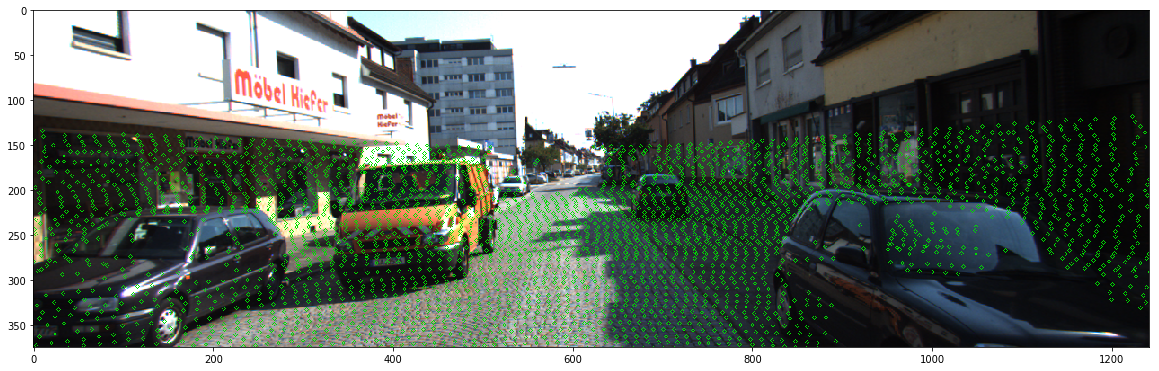

In [39]:

dataset_velo = list(dataset.velo)
dataset_rgb = list(dataset.rgb)
frame = 0
calib_dir ="/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset/2011_09_26/"


#velo_data = convert_velo_cord_to_img(dataset, calib_dir)
velo_data = convert_velo_cord_to_img(dataset_velo, calib_dir)
#rgb_img = dataset.rgb[frame].right

rgb_img = dataset_rgb[frame][frame]
#rgb_img = dataset.rgb[frame][0]
#rgb_img = dataset
#corped_velo_data = crop_velo_to_img_size(rgb_img.shape, velo_data)
corped_velo_data = crop_velo_to_img_size([400,1500,3], velo_data)


import cv2
print(cv2.addWeighted)
def overlay_velo_img(img, velo_data,radius = 2):
    (x, y) = velo_data
    im = np.zeros(img.shape, dtype=np.float32)
    x_axis = np.floor(x).astype(np.int32)
    y_axis = np.floor(y).astype(np.int32)
#     im[y_axis, x_axis] = [1, 0, 1]
    #print(len(x))
    #print(len(y))
    
    # below draws circles on the image
    for i in range(0, len(x)):
#         cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
            #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        #print(x_axis[i], y_axis[i])
        cv2.circle(img, (x_axis[i], y_axis[i]), radius, [0, 35, 0])
    
    fig1 = plt.figure(figsize=(20, 20))
    #plt.imshow(img)
    
    return img

result_img = overlay_velo_img(rgb_img, corped_velo_data,2)
print(corped_velo_data)
plt.imshow(result_img)

In [40]:
def convert_list_array(input_list,frame):
    #len(tracklet_rects[0])
    #print(tracklet_rects[0])

    #test = []
    iter_num = 0
    for tracklet in input_list[frame]:
        #print("tracket %",tracklet)
        if iter_num == 0:
            tracklet_rects_array = tracklet.transpose(1,0)
        else:
            #test.append(tracklet.transpose(1,0))
            tracklet_rects_array = np.concatenate((tracklet_rects_array, tracklet.transpose(1,0)), axis=0)

        iter_num = iter_num + 1

    #print(tracklet_rects_array)
    #type(tracklet_rects_array)
    
    return tracklet_rects_array

In [41]:
#dataset_velo[0]

#type(dataset_velo[0])

In [42]:
#dataset_tracklets = convert_list_array(tracklet_rects,0)
#print("dataset_tracklets %",dataset_tracklets)

#velo_data_tracklets = convert_velo_cord_to_img(dataset_tracklets, calib_dir,7, 2, 0,True)

#corped_velo_data_tracklets = crop_velo_to_img_size([400,1500,3], velo_data_tracklets)

#print(corped_velo_data_tracklets)
#result_img_w_tracklets = overlay_velo_img(rgb_img, corped_velo_data_tracklets,100)

#plt.imshow(result_img_w_tracklets)

#plt.scatter(corped_velo_data_tracklets[0],corped_velo_data_tracklets[1])

In [43]:
#cv2.drawContours(img,[box],0,(0,0,255),2)


#test = np.array([corped_velo_data_tracklets[0],corped_velo_data_tracklets[1]])

#vertices = np.array([[(test.transpose(1,0)[0]),
#                      (test.transpose(1,0)[1]), 
#                      (test.transpose(1,0)[2]), 
#                      (test.transpose(1,0)[3]),
#                      (test.transpose(1,0)[4]),
#                      (test.transpose(1,0)[5]),
#                      (test.transpose(1,0)[6]),
#                      (test.transpose(1,0)[7])]],
#                    dtype=np.int32)
#vertices
#cv2.drawContours(rgb_img, vertices,-1, (0,255,0), 3)

#fig1 = plt.figure(figsize=(20, 20))
#plt.imshow(rgb_img)

0
[[ 517.7704  417.3281  320.6517  476.789   516.8382  416.5401  319.6495
   475.4383]
 [ 263.9882  265.3242  312.1372  309.8265  162.9052  163.9035  154.7138
   153.2153]]
8
0
[[ 293.3224  178.6825  109.0719  292.7283  178.2514  108.539 ]
 [ 310.687   312.4374  391.4442  211.1872  212.513   230.1307]]
6
0
[[ 1006.9508   821.8197  1004.2498   819.5883]
 [  354.7611   354.6736   188.8345   190.6414]]
4
0
[[ 674.0974  732.7125  713.3921  663.9854  673.5178  732.0901  712.8793
   663.503 ]
 [ 232.2747  231.656   223.6029  224.1245  181.8294  181.2106  181.0824
   181.6041]]
8
0
[[ 550.327   524.5751  517.2817  545.2978  550.1231  524.379   517.0708
   545.0776]
 [ 205.6492  205.9238  208.1659  207.8669  184.6283  184.9007  185.2947
   184.9983]]
8


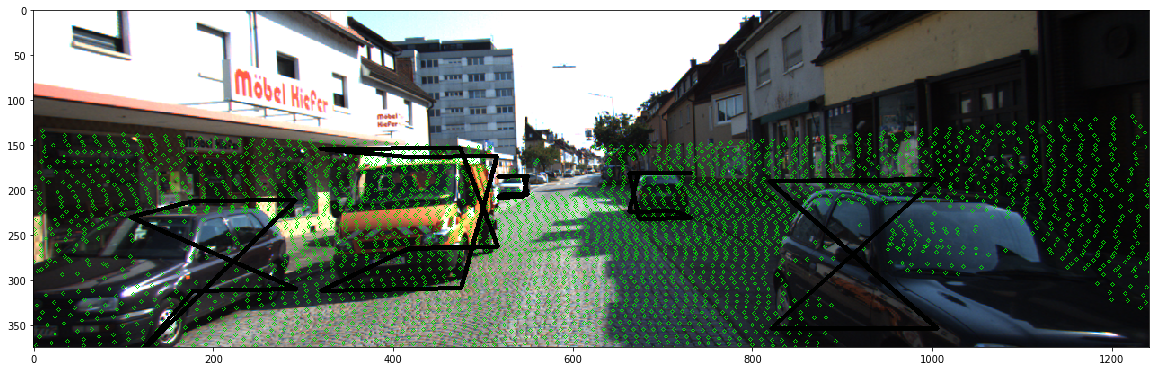

In [45]:
max_iter = 0
frame = 0
tracklet = 0
for rect in tracklet_rects[frame]:
    
    tracklet = tracklet + 1
    
    dataset_tracklets = rect.transpose(1,0)

    velo_data_tracklets = convert_velo_cord_to_img(dataset_tracklets, calib_dir,7, 2, 0,True)

    corped_velo_data_tracklets = crop_velo_to_img_size([400,1500,3], velo_data_tracklets)

    test = np.array([corped_velo_data_tracklets[0],corped_velo_data_tracklets[1]])
    print(test)
    print(len(corped_velo_data_tracklets[0]))

    if len(corped_velo_data_tracklets[0]) ==8:
        vertices = np.array([[(test.transpose(1,0)[0]),
                              (test.transpose(1,0)[1]), 
                              (test.transpose(1,0)[2]), 
                              (test.transpose(1,0)[3]),
                              (test.transpose(1,0)[4]),
                              (test.transpose(1,0)[5]),
                              (test.transpose(1,0)[6]),
                              (test.transpose(1,0)[7])]],
                            dtype=np.int32)
    elif len(corped_velo_data_tracklets[0]) ==6:
        vertices = np.array([[(test.transpose(1,0)[0]),
                              (test.transpose(1,0)[1]), 
                              (test.transpose(1,0)[2]), 
                              (test.transpose(1,0)[3]),
                              (test.transpose(1,0)[4]),
                              (test.transpose(1,0)[5])]],
                            dtype=np.int32)
    
    elif len(corped_velo_data_tracklets[0]) ==4:
        vertices = np.array([[(test.transpose(1,0)[0]),
                              (test.transpose(1,0)[1]), 
                              (test.transpose(1,0)[2]), 
                              (test.transpose(1,0)[3])]],
                            dtype=np.int32)
    #vertices
    cv2.drawContours(rgb_img, vertices,-1, (0,255,0), 3)
    
    tracklet = tracklet + 1

fig1 = plt.figure(figsize=(20, 20))
plt.imshow(rgb_img)

In [ ]:
tracklet_rects[0][0]#[0].shape

tracklet_types[0][0]

In [ ]:
tracklet_rects[0][0].shape

In [ ]:
np.reshape(tracklet_rects[0][0],(8,3))

In [ ]:
print(tracklet_rects[0][0].transpose(1,0).shape)

In [ ]:
dataset_velo[0].shape

In [ ]:
dataset_velo[0][10]

In [ ]:
dataset_tracklets[0][0].shape